In [1]:
import math
import numpy as np
import copy
import matplotlib.pyplot as plt
import csv

# 壁体関連情報を保持するクラス

## 1) 壁体構成部材の情報を保持するクラス

壁体の各層の構成部材情報（部材名称、熱伝導率、容積比熱、厚さ、等）を保持するクラスを定義します。

- 部材名称　string
- 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup>
- 容積比熱, kJ m<sup>-3</sup> K<sup>-1</sup>
- 厚さ(m)

#### Definition

In [2]:
#壁体構成部材のクラス
class Layer:
    
    # 初期化
    def __init__(self, name, cond, spech, thick):
        self.__name = name        # 部材名称, string値
        self.__dblLam = cond              # 熱伝導率[W/(m・K)]
        self.__dblSpcheat = spech * 1000  # 容積比熱[kJ/(m3・K)] → [J/(m3・K)]
        self.__dblDim = thick             # 厚さ[m]
        
    # 部材名称の取得
    @property
    def name(self):
        return self.__name
    
    # 熱伝導率[W/(m・K)]の取得
    def dblLam(self):
        return self.__dblLam
    
    # 容積比熱[J/(m3・K)]の取得
    def dblSpcheat(self):
        return self.__dblSpcheat
    
    # 厚さ[m]の取得
    def dblDim(self):
        return self.__dblDim
    
    # 熱抵抗[(m2・K)/W]の取得
    def dblR(self):
        if abs(self.__dblDim) < 0.001:
            resistance = 1 / self.__dblLam # 厚さが0.0mの場合は分子を1とする
        else:
            resistance = self.__dblDim / self.__dblLam
        return resistance

    # 熱容量[J/(m2・K)]の取得
    def dblC(self):
        return self.__dblSpcheat * self.__dblDim

### Example

In [3]:
layers =[
    Layer( 'PlasterBoard', 0.22, 830.0, 0.012 ),
    Layer( 'GW16K', 0.045, 13.0, 0.1 ),
    Layer( 'AirSpace', 11.11, 0.0, 0.0 ),
    Layer( 'Plywood', 0.16, 720.0, 0.009 ),
    Layer( 'Mortar', 1.5, 1600.0, 0.003 ),
    Layer( 'OutHeatTrans', 25.0, 0.0, 0.00 )
]

for i , layer in enumerate( layers ):
    print( 'layer[' , i , '] C:' , layer.dblC() , '[J/(m2・K)]')

layer[ 0 ] C: 9960.0 [J/(m2・K)]
layer[ 1 ] C: 1300.0 [J/(m2・K)]
layer[ 2 ] C: 0.0 [J/(m2・K)]
layer[ 3 ] C: 6479.999999999999 [J/(m2・K)]
layer[ 4 ] C: 4800.0 [J/(m2・K)]
layer[ 5 ] C: 0.0 [J/(m2・K)]


## 2) 壁体情報を保持するクラス
- 壁体の基本情報（壁体名称、層構成、熱伝達率等）を保持するクラスを定義します。

### Constructor parameters
```
'Name'           : 壁体名称
#######'OutHeatTrans'   : 室外側熱伝達率[W/(m2・K)]
'OutEmissiv'     : 室外側放射率[-]
'OutSolarAbs'    : 室外側日射吸収率[-]
'InConHeatTrans' : 室内対流熱伝達率[W/(m2･K)]
'InRadHeatTrans' : 室内放射熱伝達率[W/(m2･K)]
'Layers'         : 壁体構成部材の情報クラスの配列
```
### Class Definition

In [4]:
class Wall:
    
    # 初期化
    def __init__(self, Name, OutEmissiv, OutSolarAbs, InConHeatTrans, InRadHeatTrans, Layers ):
        self.__Name = Name               # 壁体名称, string値
        #self.__dblho = OutHeatTrans      # 室外側熱伝達率[W/(m2・K)]
        self.__dblEo = OutEmissiv        # 室外側放射率[-]
        self.__dblas = OutSolarAbs       # 室外側日射吸収率[-]
        self.__dblhic = InConHeatTrans   # 室内対流熱伝達率[W/(m2･K)]
        self.__dblhir = InRadHeatTrans   # 室内放射熱伝達率[W/(m2･K)]
        self.__dblhi = self.__dblhic + self.__dblhir   # 室内総合熱伝達率[W/(m2･K)]
        self.__Layers = copy.deepcopy( Layers )
    
    # 名前の取得
    def Name(self):
        return self.__Name
        
    # 室内側熱伝達率の取得
    def hi(self):
        return self.__dblhi
    
    # 室内側対流熱伝達率の取得
    def hic(self):
        return self.__dblhic

    # 室内側放射熱伝達率の取得
    def hir(self):
        return self.__dblhir

    # 室外側熱伝達率の取得
    def ho(self):
        n = len(self.__Layers)
        #print('n=', n)
        layer = self.__Layers[n-1]
        return layer.dblLam()

    # 室外側放射率の取得
    def Eo(self):
        return self.__dblEo

    # 室外側日射吸収率の取得
    def  Solas(self):
        return self.__dblas
    
    # 壁体構成部材配列を取得
    def Layers(self):
        return self.__Layers
        #return list(self.__Layers)
    
    # 壁体の構成部材数を取得
    def lngNlayer(self):
        return len(self.__Layers)
    
    # 室外側熱伝達率[W/(m2・K)]を壁体構成部材情報クラスの配列に追加する
    #（応答係数計算用）
    # 室外側熱伝達率は層構成と同時に設定するように仕様変更（2018/8/24）
#    def AppendOutHeatTrans(self):
#        self.__Layers.append( Layer( 'OutHeatTrans', self.__dblho, 0.0, 0.00 ) )

### Example

In [5]:
layers_test = [
    Layer( 'Plywood', 0.16, 720.0, 0.022 ),
    Layer( 'GW16K', 0.045, 13.0, 0.150 ),
    Layer( 'Ro', 25.0, 0.0, 0.0)
]
wall_test = Wall( '1F_floor', 0.90, 0.80, 1.70, 5.00, layers_test )
#print( 'ho=', wall_test.ho())
#wall_test.AppendOutHeatTrans()
for i , layer in enumerate( wall_test.Layers() ):
    print( 'layer[' , i , '] Name:' , layer.name, ' R:',  layer.dblR(), '[(m2・K)/W]' )

layer[ 0 ] Name: Plywood  R: 0.13749999999999998 [(m2・K)/W]
layer[ 1 ] Name: GW16K  R: 3.3333333333333335 [(m2・K)/W]
layer[ 2 ] Name: Ro  R: 0.04 [(m2・K)/W]


## 3）応答係数を保持するクラス
- 壁体の応答係数を保持するクラスを定義します。

### Constructor parameters
```
'WallType'    : 壁体種類,　'wall' or 'soil'
'dblDTime'    : 計算時間間隔[s]
'dblNcalTime' : 応答係数を作成する時間数[h]
'Wall'        : 壁体情報クラス
```
### Class Definition

In [6]:
# 応答係数
class ResponseFactor():
    
    # 初期化
    def __init__(self, WallType, dblDTime, dblNcalTime, Wall):
        # WallType as string   : 壁体種類, 'wall' or 'soil'
        # dblDTime as long    : 計算時間間隔[s]
        # dblNcalTime as long : 応答係数を作成する時間数[h]
        # wall as dictionary : 壁体基本情報クラス
        
        # VBAからの主な変更点：
        # (1)二次元配列（objArray）で壁体の情報を受け取っていたが、壁体情報クラスで受け取るように変更
        # (2)lngStRow, lngOutputColは削除
        # (3)固定根はシートから読み込んでいたが、初期化時に配列として与えるように変更
        # (4)伝達関数近似のA0の周期は使用しない

        self.__dblDTime = dblDTime           # 計算時間間隔[s]
        self.__dblNcalTime = dblNcalTime     # 応答係数を作成する時間数
        self.__lngM = int(self.__dblNcalTime * 3600 / self.__dblDTime) + 1  # 応答係数で作成する項数
        self.__wall = Wall                   # 壁体情報クラス
        
        # 固定根の設定
        if WallType == 'wall':
            dblAlps = [ 0.000002, 0.0000078997702574515, 0.0000312031850602576,
                       0.000123248996638389, 0.000486819378952343, 
                       0.00192288062529936, 0.00759515758618483, 0.03 ]
        elif WallType == 'soil':
            dblAlps = [ 1.0597E-09, 4.2389E-09, 1.6956E-08, 6.7806E-08, 2.7128E-07,
                       1.0850E-06, 4.3417E-06, 1.7361E-05, 6.94444E-05, 0.000277778 ]
        else:
            raise ValueError('指定されたWallTypeの固定根は定義されていません')
        self.__dblAlp = dblAlps
        self.__lngNroot = len( self.__dblAlp ) # 根の数
        
        # ラプラス変数の設定
        # ラプラス変数が定義されている場合に対応する？
        self.__lngNLaps = self.__lngNroot * 2    # 与えるラプラス変数の個数
        self.__dblLaps = []                      # ラプラス変数の配列
        for lngI in range( 1, self.__lngNLaps + 1 ):
            if lngI % 2 == 0:
                # 偶数番目はαをそのまま入力
                self.__dblLaps.append( self.__dblAlp[int((lngI-1) / 2)] ) 
            elif lngI == 1:
                # 最初はα1/√(α2/α1）とする
                self.__dblLaps.append( self.__dblAlp[0] / math.sqrt( self.__dblAlp[1] / self.__dblAlp[0] ) )
            else:
                # それ以外は等比数列で補間
                lngL = math.ceil( (lngI-1) / 2 )
                self.__dblLaps.append( self.__dblAlp[lngL] / math.sqrt( self.__dblAlp[lngL] / self.__dblAlp[lngL - 1] ) )
        
        # 応答係数計算のため、壁体構成部材情報クラスの配列に室外側熱伝達率[W/(m2・K)]を追加する
        # 室外側熱伝達率は壁体層構成を入力するときに設定するように変更（2018/8/24）
        #self.__wall.AppendOutHeatTrans()
   
        # 単位応答の計算
        self.__dblAT0, self.__dblAA0, self.__dblAT, self.__dblAA, self.__dblATstep, self.__dblAAstep = self.StepRespOfWall()
        
        # 二等辺三角波励振の応答係数、指数項別応答係数、公比の計算
        self.__dblRFT, self.__dblRFA, self.__dblRFT1, self.__dblRFA1, self.__dblRow = self.RFTRI()
        
         
    # 壁体の単位応答の計算
    def StepRespOfWall(self):
        
        # 四端子基本行列の初期化
        matFi = [ 0.0 for i in range( self.__wall.lngNlayer() ) ]
        for lngK in range( self.__wall.lngNlayer() ):
            #matFi[lngK] = np.zeros((2,2))
            matFi[lngK] = [ [ 0.0 for i in range(2) ] for j in range(2) ]
        
        # 吸熱、貫流の各伝達関数ベクトルの初期化
        matGA = [ [ 0.0 for i in  range(1) ] for j in range(self.__lngNLaps) ]
        matGT = [ [ 0.0 for i in  range(1) ] for j in range(self.__lngNLaps) ]
        
        # 単位貫流応答、単位吸熱応答の初期化
        dblAA0 = 0.0
        dblAT0= 1.0
        dblCtotal = 0.0
        for layer in self.__wall.Layers():
            dblAA0 += layer.dblR()
            dblCtotal += layer.dblC()
            
        # GA(0), GT(0)
        dblGA0 = dblAA0
        dblGT0 = dblAT0
        
        # 壁体の熱容量が0（定常）の場合
        # 定常部位であっても、そのまま処理を継続する（計算上は問題ないため）
        #if abs(dblCtotal) < 0.001:
        #    pass #　暫定処理（VBAではここで処理を抜ける）
    
        # 四端子行列の作成
        for lngI, laps in enumerate(self.__dblLaps):
            
            # 四端子行列の初期化
            matFt = [ [ 0.0 for i in range(2) ] for j in range(2) ]
            
            # 四端子基本行列の作成
            for lngK, layer in enumerate(self.__wall.Layers()):
                # 定常部位（空気層等）の場合
                if abs( layer.dblC() ) < 0.001:
                    matFi[lngK][0][0] = 1.0
                    matFi[lngK][0][1] = layer.dblR()
                    matFi[lngK][1][0] = 0.0
                    matFi[lngK][1][1] = 1.0
                # 非定常部位の場合
                else:
                    dblTemp = math.sqrt( layer.dblR() * layer.dblC() * laps )
                    dblCosh = np.cosh( dblTemp )
                    dblSinh = np.sinh( dblTemp )
                    matFi[lngK][0][0] = dblCosh
                    matFi[lngK][0][1] = layer.dblR() / dblTemp * dblSinh
                    matFi[lngK][1][0] = dblTemp / layer.dblR() * dblSinh
                    matFi[lngK][1][1] = dblCosh
                
                # 室内側1層目の場合は、四端子行列に四端子基本行列をコピーする
                if lngK == 0:
                    matFt = copy.deepcopy( matFi[lngK] )
                    # 室内側2層目以降は、四端子基本行列を乗算
                else:
                    matTemp = copy.deepcopy( matFt )
                    matFt = np.dot( matTemp, matFi[lngK] )
                    
                # 吸熱、貫流の各伝達関数ベクトルの作成
                matGA[lngI][0] = matFt[0][1] / matFt[1][1] - dblGA0
                matGT[lngI][0] = 1.0 / matFt[1][1] - dblGT0

        # 伝達関数の係数を求めるための左辺行列を作成
        matF = [ [ 0.0 for i in range(self.__lngNroot) ] for j in range(self.__lngNLaps) ]
        for lngI, laps in enumerate(self.__dblLaps):
            for lngJ, root in enumerate(self.__dblAlp):
                matF[lngI][lngJ] = laps / ( laps + root )
        
        # 最小二乗法のための係数行列を作成
        matU = [ [ 0.0 for i in range(self.__lngNroot) ] for j in range(self.__lngNroot) ]
        for lngK in range(self.__lngNroot):
            for lngJ in range(self.__lngNroot):
                dblTemp = 0.0
                for lngI in range(self.__lngNLaps):
                    dblTemp = dblTemp + matF[lngI][lngK] * matF[lngI][lngJ]
                matU[lngK][lngJ] = dblTemp
        
        # 最小二乗法のための定数項行列を作成
        matCA = [ [ 0.0 for i in range(1) ] for j in range(self.__lngNroot) ]
        matCT = [ [ 0.0 for i in range(1) ] for j in range(self.__lngNroot) ]
        for lngK in range(self.__lngNroot):
            dblTempA = 0.0
            dblTempT = 0.0
            for lngI in range(self.__lngNLaps):
                dblTempA = dblTempA + matF[lngI][lngK] * matGA[lngI][0]
                dblTempT = dblTempT + matF[lngI][lngK] * matGT[lngI][0]
            matCA[lngK][0] = dblTempA
            matCT[lngK][0] = dblTempT
        
        # 最小二乗法のための係数行列の逆行列を計算
        matU_inv = np.linalg.inv(matU)
        
        # 伝達関数の係数を計算
        matAA = np.dot( matU_inv, matCA )
        matAT = np.dot( matU_inv, matCT )
        
        # 伝達関数の係数を一次元配列に変換
        dblAT = [ 0.0 for i in range( self.__lngNroot ) ]
        dblAA = [ 0.0 for i in range( self.__lngNroot ) ]
        for lngI in range(self.__lngNroot):
            dblAT[lngI] = matAT[lngI][0]
            dblAA[lngI] = matAA[lngI][0]
        
        # 単位応答を計算
        dblATstep = [ 0.0 for i in range( self.__lngM ) ]
        dblAAstep = [ 0.0 for i in range( self.__lngM ) ]
        for lngJ in range(self.__lngM):
            dblATstep[lngJ] = dblAT0
            dblAAstep[lngJ] = dblAA0
            for lngK, root in enumerate(self.__dblAlp):
                dblATstep[lngJ] = dblATstep[lngJ] + dblAT[lngK] * math.exp( -root * lngJ * self.__dblDTime )
                dblAAstep[lngJ] = dblAAstep[lngJ] + dblAA[lngK] * math.exp( -root * lngJ * self.__dblDTime )
                
        # デバッグ用
        #print('四端子基本行列：', matFi)
        #print('四端子行列：', matFt)
        #print('貫流伝達関数ベクトル：', matGA)
        #print('吸熱伝達関数ベクトル：', matGT)
        #print('伝達関数の係数を求めるための左辺行列：', matF)
        #print('最小二乗法のための係数行列：', matU)
        #print('最小二乗法のための係数行列の逆行列：', matU_inv)
        #print('貫流定数項行列：', matCT)
        #print('吸熱定数項行列：', matCA)
        #print('貫流伝達関数の係数：', dblAT)
        #print('吸熱伝達関数の係数：', dblAA)
        #print('単位貫流応答：', dblATstep[:11])
        #print('単位吸熱応答：', dblAAstep[:11])
        
        return dblAT0, dblAA0, copy.deepcopy(dblAT), copy.deepcopy(dblAA), copy.deepcopy(dblATstep), copy.deepcopy(dblAAstep)
    
    
    # 二等辺三角波励振の応答係数、指数項別応答係数、公比の計算
    def RFTRI(self):
        
        #二等辺三角波励振の応答係数の配列を初期化
        dblRFT = [ 0.0 for i in range( self.__lngM ) ]
        dblRFA = [ 0.0 for i in range( self.__lngM ) ]
        
        #二等辺三角波励振の応答係数の初項を計算
        dblRFT[0] = self.__dblAT0
        dblRFA[0] = self.__dblAA0
        for lngI, root in enumerate(self.__dblAlp):
            dblTemp = root * self.__dblDTime
            dblE1 = ( 1.0 - math.exp(-dblTemp) ) / dblTemp
            dblRFT[0] = dblRFT[0] + dblE1 * self.__dblAT[lngI]
            dblRFA[0] = dblRFA[0] + dblE1 * self.__dblAA[lngI]
        
        #二等辺三角波励振の応答係数の二項目以降を計算
        for lngJ in range(1, self.__lngM):
            dblRFT[lngJ] = 0.0
            dblRFA[lngJ] = 0.0
            for lngI, root in enumerate(self.__dblAlp):
                dblTemp = root * self.__dblDTime
                dblE1 = ( 1.0 - math.exp(-dblTemp) ) ** 2 * math.exp( -(lngJ - 1) * dblTemp ) / dblTemp
                dblRFT[lngJ] = dblRFT[lngJ] - dblE1 * self.__dblAT[lngI]
                dblRFA[lngJ] = dblRFA[lngJ] - dblE1 * self.__dblAA[lngI]
            
        # 指数項別応答係数、公比を計算
        dblRFT1 = [ 0.0 for i in range( self.__lngNroot ) ]
        dblRFA1 = [ 0.0 for i in range( self.__lngNroot ) ]
        dblRow = [ 0.0 for i in range( self.__lngNroot ) ]
        for lngI, root in enumerate(self.__dblAlp):
            dblTemp = root * self.__dblDTime
            dblE1 = 1.0 / dblTemp * ( 1.0 - math.exp(-dblTemp) ) ** 2
            dblRFT1[lngI] = - self.__dblAT[lngI] * dblE1
            dblRFA1[lngI] = - self.__dblAA[lngI] * dblE1
            dblRow[lngI] = math.exp(-dblTemp)
                         
        # デバッグ用
        #print('貫流応答係数：', dblRFT[:11])
        #print('吸熱応答係数：', dblRFA[:11])
        #print('指数項別貫流応答係数：', dblRFT1)
        #print('指数項別吸熱応答係数：', dblRFA1)
        #print('公比：', dblRow)
        
        return copy.deepcopy(dblRFT), copy.deepcopy(dblRFA), copy.deepcopy(dblRFT1), copy.deepcopy(dblRFA1), copy.deepcopy(dblRow)

    # 壁体情報の取得
    def Wall(self):
        return self.__wall
    
    # 単位貫流応答の取得
    def ATstep(self):
        return self.__dblATstep
    
    # 単位吸熱応答の取得
    def AAstep(self):
        return self.__dblAAstep
    
    # 二等辺三角波励振の貫流応答係数の取得
    def RFT(self):
        return self.__dblRFT
    
    # 二等辺三角波励振の吸熱応答係数の取得
    def RFA(self):
        return self.__dblRFA

    # 公比の取得
    def Row(self):
        return self.__dblRow
    
    # 指数項別貫流応答係数の取得
    def RFT1(self):
        return self.__dblRFT1
    
    # 指数項別吸熱応答係数の取得
    def RFA1(self):
        return self.__dblRFA1
    
    # 貫流応答係数の初項
    def RFT0(self):
        return self.__dblRFT[0]

    # 吸熱応答係数の初項
    def RFA0(self):
        return self.__dblRFA[0]

    # 根の取得
    def Alp(self):
        return self.__dblAlp

### Example

In [7]:
layers =[
    Layer( 'Plywood', 0.16, 720.0, 0.022 ),
    Layer( 'GW16K', 0.045, 13.0, 0.150 ),
]
wall = Wall( '1F_floor', 0.90, 0.80, 1.70, 5.00, layers )
rf = ResponseFactor('wall', 3600, 50, wall)

####  単位応答の取得

In [8]:
print(rf.Wall().Name())
print('単位貫流応答(12項まで)：', rf.ATstep()[:12] )
print('単位吸熱応答(12項まで)：', rf.AAstep()[:12] )

1F_floor
単位貫流応答(12項まで)： [0.013988846779284358, 0.04937260209936714, 0.09883817010791168, 0.14290363646731935, 0.19140304602054878, 0.24241026758104134, 0.2934211486684445, 0.34276779593381995, 0.3895114553015459, 0.43319966732584675, 0.47368184765756555, 0.5109874107254245]
単位吸熱応答(12項まで)： [0.04795445729999637, 0.300289500051962, 0.4680462191596034, 0.6141578246980857, 0.77500253747064, 0.9445484841557964, 1.1143779704588688, 1.278832039563816, 1.434709634558551, 1.5804561121371763, 1.7155406376416182, 1.840043749427306]


#### 二等辺三角波励振の応答係数の取得

In [9]:
print(rf.Wall().Name())
print('二等辺三角波励振の貫流応答係数(12項まで)：', rf.RFT()[:12] )
print('二等辺三角波励振の吸熱応答係数(12項まで)：', rf.RFA()[:12] )

1F_floor
二等辺三角波励振の貫流応答係数(12項まで)： [0.014185745037654409, 0.0617444808311913, 0.0446111100605324, 0.04628562882155728, 0.049986360061663584, 0.05118465497814049, 0.0502834550480831, 0.048099755108736555, 0.04523877847741358, 0.0420887781679088, 0.0388862287821933, 0.03576937658859137]
二等辺三角波励振の吸熱応答係数(12項まで)： [0.15886872908980276, 0.23209547481470155, 0.14909740344601535, 0.15340400289982564, 0.1659717114135441, 0.17028201512953503, 0.1674979847710565, 0.16035264485174344, 0.15089120584300567, 0.14042929740322727, 0.12976944991550707, 0.11938163910318318]


#### 応答係数の初項の取得

In [10]:
rf.RFT0()

0.014185745037654409

In [11]:
rf.RFA0()

0.15886872908980276

#### 指数項別応答係数の取得

In [12]:
print(rf.Wall().Name())
print('指数項別貫流応答係数：', rf.RFT1() )
print('指数項別吸熱応答係数：', rf.RFA1() )

1F_floor
指数項別貫流応答係数： [-0.0003208711816947076, 0.010246356604820754, 0.09052204171318749, -0.09127213540469793, 0.07301681131154365, -0.024033571790889788, 0.004127459970857314, -0.0005416103919355077]
指数項別吸熱応答係数： [-0.0010649239042534195, 0.034077572476333765, 0.30253736711769347, -0.30891401892674425, 0.25916957436527893, -0.0648929965229092, 0.012721097048949024, -0.0015381968396468437]


#### 根、公比の取得

In [13]:
print(rf.Wall().Name())
print('公比：', rf.Row() )
print('根：', rf.Alp() )

1F_floor
公比： [0.9928258579038134, 0.9719614139161242, 0.8937479611413874, 0.6416602070602015, 0.17333142526386758, 0.0009854913082178731, 1.3343627080987643e-12, 1.2479464629129513e-47]
根： [2e-06, 7.8997702574515e-06, 3.12031850602576e-05, 0.000123248996638389, 0.000486819378952343, 0.00192288062529936, 0.00759515758618483, 0.03]


#### 単位応答のグラフ描画

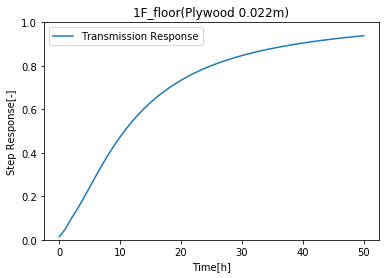

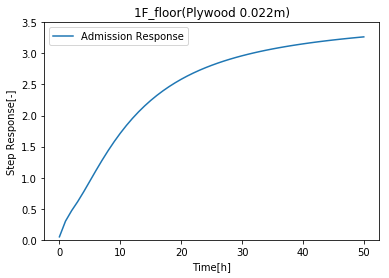

In [14]:
# X軸の値を用意
TimeArray = range(len(rf.ATstep()))

# グラフタイトルの用意
title = rf.Wall().Name() + '('
for i, layer in enumerate(rf.Wall().Layers()):
    if i == len(rf.Wall().Layers()) - 2:
        title = title + layer.name +  ' ' + str( layer.dblDim()) + 'm)'
    elif i == len(rf.Wall().Layers()) - 1:
        break
    else:
        title = title + layer.name +  ' ' + str( layer.dblDim()) + 'm, '

# 単位貫流応答のグラフ描画
plt.plot( TimeArray, rf.ATstep(), label = 'Transmission Response')
plt.title( title )
plt.xlabel('Time[h]')
plt.ylabel('Step Response[-]')
plt.ylim(0, 1)
plt.legend()
plt.show()

# 単位吸熱応答のグラフ描画
plt.plot( TimeArray, rf.AAstep(), label = 'Admission Response')
plt.title(title)
plt.xlabel('Time[h]')
plt.ylabel('Step Response[-]')
plt.ylim(0, 3.5)
plt.legend()
plt.show()